In [3]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from jkinpylib.conversions import (
    quaternion_inverse,
    quaternion_to_rotation_matrix,
    geodesic_distance_between_rotation_matrices,
    quaternion_conjugate,
    quaternion_norm,
    geodesic_distance_between_quaternions,
    quatconj,
    quaternion_product,
    quatmul,
    single_axis_angle_to_rotation_matrix, 
    rotation_matrix_to_quaternion
)
from jkinpylib.utils import set_seed, to_torch
from jkinpylib.robots import FetchArm
from torchviz import make_dot

# Set seed to ensure reproducibility
set_seed()

torch.set_printoptions(linewidth=5000, precision=6, sci_mode=False)

set_seed() - random int:  44


In [18]:
robot = FetchArm()

Heads up: Setting joint limits to [-pi, pi] for continuous joint 'r_wheel_joint'
Heads up: Setting joint limits to [-pi, pi] for continuous joint 'l_wheel_joint'
Heads up: Setting joint limits to [-pi, pi] for continuous joint 'upperarm_roll_joint'
Heads up: Setting joint limits to [-pi, pi] for continuous joint 'forearm_roll_joint'
Heads up: Setting joint limits to [-pi, pi] for continuous joint 'wrist_roll_joint'
WorldModel::LoadRobot: /tmp/fetch_formatted_link_filepaths_absolute.urdf
joint limit: no lower, defaults to 0joint limit: no upper, , defaults to 0joint limit: no lower, defaults to 0joint limit: no upper, , defaults to 0URDFParser: joint dynamics: no friction, defaults to 0
URDFParser: joint dynamics: no friction, defaults to 0
URDFParser: joint dynamics: no friction, defaults to 0
joint limit: no lower, defaults to 0joint limit: no upper, , defaults to 0URDFParser: joint dynamics: no friction, defaults to 0
URDFParser: joint dynamics: no friction, defaults to 0
joint limit

# Norm of theta gradient  as a function of angular distance from target pose
This plot shows the norm of theta's gradient as a function of the realized pose's error from a target pose

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1484.71it/s]


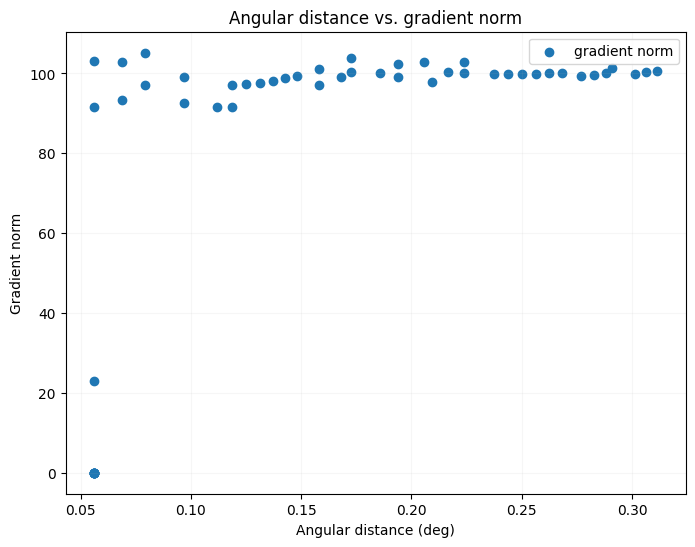

In [23]:
device = "cuda"

joint_angle, target_pose = robot.sample_joint_angles_and_poses(1)
joint_angle = to_torch(joint_angle, device=device)
target_pose = to_torch(target_pose, device=device)

ang_dists = []
grad_norms = []
grads_individuals = []

for i in range(50):
    i = 50 - i - 1
    theta = joint_angle.clone()
    offset = 0.000025*i*torch.ones(theta.shape,dtype=torch.float32, device=device)
    theta += offset
    theta = theta.clone().detach().requires_grad_(True)
    pose_fk = robot.forward_kinematics_batch(theta, out_device=device)
    dist = torch.rad2deg(geodesic_distance_between_quaternions(pose_fk[:, 3:], target_pose[:, 3:])[0])
    dist.backward()
    norm =  torch.norm(theta.grad)
    ang_dists.append(dist.item())
    if torch.isnan(norm):
        grad_norms.append(-0.1)
    else:
        grad_norms.append(norm.item())
    
    # Get the gradient of individual joints  
    individuals = [theta.grad[0, j] for j in range(robot.n_dofs)]
    grads = []
    for ind in individuals:
        if torch.isnan(ind):
            grads.append(-0.1)
        else:
            grads.append(ind.item())    
    grads_individuals.append(grads)

for d, gn, grads in zip(ang_dists, grad_norms, grads_individuals):
    assert type(d) == type(gn)
    for grad in grads:
        assert type(d) == type(grad)
        
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.grid(alpha=0.1)
ax.set_title('Angular distance vs. gradient norm')
ax.set_xlabel('Angular distance (deg)')
ax.set_ylabel('Gradient norm')
ax.scatter(ang_dists, grad_norms, label="gradient norm")
grads_joint1 = [g[0] for g in grads_individuals]
grads_joint2 = [g[1] for g in grads_individuals]
ax.legend()

# Gradient  as a function of angular distance from target pose
In this example a quaternion $q_{\textrm{delta}}$ is parameterized by a single scalar $x$. This quaternion rotates a different quaternion $q$ from its initial state $q_{\textrm{target}}$ to $q_{\textrm{new}}$. The angle $\phi$ is calculated as the rotational distance between $q_{\textrm{target}}$ and $q_{\textrm{new}}$. Autodiff is run with $\phi$ as a loss term. This is repeated for multiple $x$ values. To show the results, grad($x$) is plotted as a function of $x$  

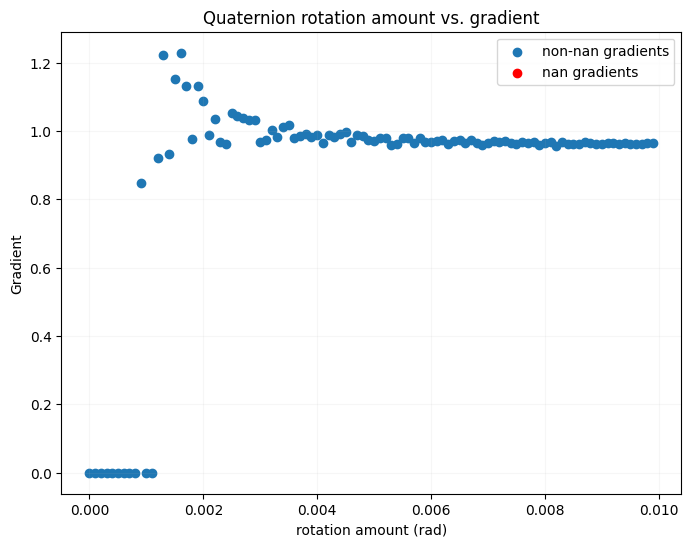

In [16]:
device = "cuda"

# q_target = torch.tensor([[1.0, 0., 0., 0.]], dtype=torch.float32, device=device)
q_target = torch.tensor([[0.8775826, 0.4794255, 0, 0]], dtype=torch.float32, device=device) # rot +x by 1rad

dists_good = [] 
dists_nan = [] 
grads_good = []
grads_nan = []
    
for i in range(0, 1000, 10):

    angle_delta = i*0.00001
    x = torch.tensor([[angle_delta]], dtype=torch.float32, device=device, requires_grad=True)    
    M = single_axis_angle_to_rotation_matrix([0., 0., 1.], x, out_device=device)

    q_delta = rotation_matrix_to_quaternion(M) 
    q_new = quatmul(q_delta, quatmul(q_target, quatconj(q_delta)))

    dist = geodesic_distance_between_quaternions(q_new, q_target)
    dist.backward()
    
    x_grad = x.grad
    if torch.isnan(x_grad):
        grads_nan.append(-0.1)
        dists_nan.append(angle_delta)
    else:
        grads_good.append(x_grad.item())
        dists_good.append(angle_delta)

dot = make_dot(dist)
dot.format = 'svg'
dot.render()
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.grid(alpha=0.1)
ax.set_title('Quaternion rotation amount vs. gradient')
ax.set_xlabel('rotation amount (rad)')
ax.set_ylabel('Gradient')
ax.scatter(dists_good, grads_good, label="non-nan gradients")
ax.scatter(dists_nan, grads_nan, label="nan gradients", color="red")
ax.legend()